In [1]:
import scanpy as sc
import anndata as ad
import rpy2
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
import seaborn as sns
from glob import glob
from scipy.sparse import csr_matrix
import numpy as np
import os
os.chdir("/data")

In [2]:
paths = glob("cellranger/*/qc_filtered.h5ad")

In [3]:
adata_list=[] #reading files
names=[]
for n in paths:
    adata = sc.read_h5ad(n)
    sample = n.split("/")[1]
    adata.obs["sample_id"]=sample
    adata.obs["condition"]=sample.split("-")[0]
    adata_list.append(adata)
    names.append(sample)

In [4]:
adata=ad.concat(adata_list, index_unique="-", keys=names) #creating one object

In [5]:
del adata_list # deleting list to save memory

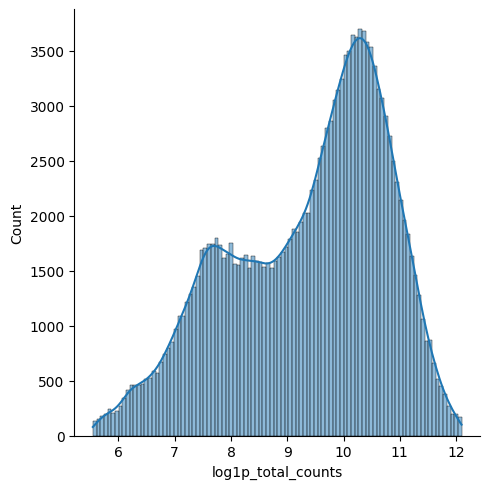

In [6]:
counts_lower=2.5
counts_upper=2
p1 = sns.displot(adata.obs["log1p_total_counts"], bins=100, kde=True)

In [7]:
adata=adata[adata.obs["total_counts"]>1000] #some samples kind of suck even after qc
#could have done on a per sample basis, just wanted to keep the stuff consistent (in terms of code)

In [8]:
sc.pp.filter_genes(adata, min_cells=3)

/home/ubuntu/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [9]:
adata.layers["cellbender"] = csr_matrix(adata.layers["cellbender"],dtype=np.float32)
adata.layers["raw"] = csr_matrix(adata.layers["raw"],dtype=np.float32)
adata.layers["counts"]=adata.layers["cellbender"]
del adata.layers["cellbender"]
adata.X = adata.layers["counts"].copy()
## converting to float32 matrices because of a weird bug in converting int64 matrices to R

In [10]:
adata.write_h5ad("full_h5ad.h5")

In [11]:
adata

AnnData object with n_obs × n_vars = 149761 × 29585
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'sample_id', 'condition'
    var: 'n_cells'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'counts'

In [12]:
del adata.layers["raw"]
del adata.layers["counts"]
del adata.obsm["cellbender_embedding"]

In [13]:
%%R -i adata
library(BiocParallel)
library(scDblFinder)
adata
#adata <- scDblFinder(adata, samples="sample_id", BPPARAM=MulticoreParam(2))

class: SingleCellExperiment 
dim: 29585 149761 
metadata(0):
assays(1): X
rownames(29585): Xkr4 Gm1992 ... ENSMUSG00000095742 ENSMUSG00000095041
rowData names(1): n_cells
colnames(149761): TGGTGATGTATCCTCC-1-cd40-1 AGGTTGTGTAAGATCA-1-cd40-1
  ... CAGCGTGAGAATTTGG-1-tak-2 GAAGAATGTTGGCTAT-1-tak-2
colData names(21): background_fraction cell_probability ... sample_id
  condition
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [14]:
del adata

In [17]:
%%R 
names(assays(adata))=c("counts")
adata <- scDblFinder(adata, samples="sample_id", BPPARAM=MulticoreParam(2))

In [19]:
%%R -o adata
adata

class: SingleCellExperiment 
dim: 29585 149761 
metadata(0):
assays(1): X
rownames(29585): Xkr4 Gm1992 ... ENSMUSG00000095742 ENSMUSG00000095041
rowData names(1): n_cells
colnames(149761): TGGTGATGTATCCTCC-1-cd40-1 AGGTTGTGTAAGATCA-1-cd40-1
  ... CAGCGTGAGAATTTGG-1-tak-2 GAAGAATGTTGGCTAT-1-tak-2
colData names(26): background_fraction cell_probability ...
  scDblFinder.weighted scDblFinder.cxds_score
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [22]:
%R rm(adata)
adata_full = sc.read_h5ad("full_h5ad.h5")

In [23]:
adata_full.obs = adata.obs.copy()
adata=adata_full.copy()
del adata_full

In [ ]:
print(f"Number of doublets: {adata[adata.obs['scDblFinder.class']=='doublet'].n_obs}")

In [16]:
adata.raw = adata #saving raw copy with doublets just in case we want to change something about this

In [17]:
adata=adata[adata.obs["scDblFinder.class"]=="singlet"].copy()

In [24]:
adata.raw.var.index=adata.raw.var.index.astype(str)
adata.obs.index=adata.obs.index.astype(str)
adata.var.index=adata.var.index.astype(str)

In [25]:
adata.write_h5ad("h5ad/doublet_filtered.h5ad")